In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import sklearn, catboost, xgboost

# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import classification_report, plot_confusion_matrix
# from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, average_precision_score, roc_curve, auc

from sklearn.preprocessing import StandardScaler

In [2]:
# Predict your new samples of silica nanoparticles by running this code, and PLEASE WAIT until the results have been downloaded

your_new_samples_id = 150
independent_id = 116
data = pd.read_csv(r'./Main_Indepedent_Dataset.csv', encoding='unicode_escape')

def convert(Cell_viability):
    if Cell_viability == 'Cytotoxic':
        return 1
    if Cell_viability == 'Non_cytotoxic':
        return 0
    else:
        return ''

def convert_back(Cell_viability):
    if Cell_viability == 1:
        return 'Cytotoxic'
    if Cell_viability == 0:
        return 'Non_cytotoxic'
    else:
      return ''

data['convert'] = data['Cell_viability'].apply(convert)
data = data.drop('Cell_viability', axis=1)
data = data.rename(columns={'convert':'Cell_viability'})

shuffled_main_dataset = data[data['Publication_id'] < independent_id].sample(frac=1, random_state=2022)
independent_dataset = data[data['Publication_id'] >= independent_id]
data = pd.concat([shuffled_main_dataset, independent_dataset])

X = data.drop(columns=['Viability_indicator','Cell_viability','Positive_control', 'Positive_control_inducer','SiO$_{2}$NP_label', 'Interference_testing','Viability_mechanism','Assay_viability'], axis=1)
# X = X.drop([
#     'SiO$_{2}$NP_medium_serum_15%_FBS',
#     'Cell_morphology_microglia',

#     'Cell_organ_heart',

#     'Cell_id_MPMC/3t3',

#     'Surface_modification_CHO',
#     'Hydrodynamic_size_water_nm_not_determined',
#     'Cell_source_hamster',
#     'Assay_viability_Sytox_Red',

#     'Viability_indicator_live_cell',
# ], axis=1)

y = data[['Cell_viability', 'Publication_id']]
y = y[y['Publication_id'] < independent_id]
y = y.drop('Publication_id',axis=1)
# y = y.to_numpy().ravel()

y_test = data[['Cell_viability','Publication_id']]
y_test = y_test[y_test['Publication_id'] >= independent_id]
y_test =  y_test.drop('Publication_id',axis=1)
y_test = y_test.values

X_test = X[X['Publication_id'] >= independent_id]
X_test = X_test.drop('Publication_id',axis=1)
X_test = X_test.sort_index(ascending=True)
X_test_shap = X_test
X_test = X_test.values.reshape(-1,len(X_test.columns))

X = X[X['Publication_id'] < independent_id]
X = X.drop('Publication_id',axis=1)


In [3]:
data

,Publication_id,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Cell_morphology,Cell_organ,Primary_size_nm,Cell_id,Exposure_time_h,Surface_modification,Hydrodynamic_size_water_nm,...,Zeta_potential_PBS/HBSS_mV,Surface_charge_culture,Zeta_potential_serum_mV,Zeta_potential_culture_mV,Cell_age,PDI_culture,Surface_charge_water,SiO$_{2}$NP_label,SiO$_{2}$NP_shape,Cell_viability
3828,104,50.0,serum_free,epithelial,liver,59.72,HepG2,72.0,unmodified,51-75,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,1
189,5,167.0,serum_free,fibroblast,skin,15.20,CCD-966sk,48.0,chitosan,not_determined,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,0
644,14,90.0,serum_free,endothelial,cell_hybrid,19.40,EAHY926,24.0,unmodified,less_26,...,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,none,sphere,1
3655,100,40.0,10%_FBS,epithelial,lung,13.00,16HBE,24.0,unmodified,151-200,...,not_determined,not_determined,negative_11-20,not_determined,non_embryonic,not_determined,negative,none,sphere,0
604,14,10.0,serum_free,endothelial,cell_hybrid,13.80,EAHY926,24.0,unmodified,less_26,...,not_determined,negative,not_determined,negative_1-10,non_embryonic,not_determined,negative,none,sphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,141,5.0,serum_free,neuronal,brain,50.00,SO,24.0,unmodified,201-300,...,not_determined,negative,negative_1-10,negative_1-10,non_embryonic,not_determined,negative,none,sphere,0
5025,141,10.0,serum_free,neuronal,brain,50.00,SO,24.0,unmodified,201-300,...,not_determined,negative,negative_1-10,negative_1-10,non_embryonic,not_determined,negative,none,sphere,0
5026,141,20.0,serum_free,neuronal,brain,50.00,SO,24.0,unmodified,201-300,...,not_determined,negative,negative_1-10,negative_1-10,non_embryonic,not_determined,negative,none,sphere,0
5027,141,40.0,serum_free,neuronal,brain,50.00,SO,24.0,unmodified,201-300,...,not_determined,negative,negative_1-10,negative_1-10,non_embryonic,not_determined,negative,none,sphere,1


In [4]:
feature_names = X.columns.tolist()
print(f"Original Feature Names: {feature_names}")

Original Feature Names: ['Concentration_µg/ml', 'SiO$_{2}$NP_medium_serum', 'Cell_morphology', 'Cell_organ', 'Primary_size_nm', 'Cell_id', 'Exposure_time_h', 'Surface_modification', 'Hydrodynamic_size_water_nm', 'Cell_source', 'Surface_area_m2/g', 'Primary_size_verification', 'Exposure_medium', 'Zeta_potential_water_mV', 'Hydrodynamic_size_culture_nm', 'SiO$_{2}$NP_synthesis', 'Hydrodynamic_size_serum_nm', 'PDI_water', 'Cell_disease', 'SiO$_{2}$NP_source', 'Cell_culture', 'Zeta_potential_PBS/HBSS_mV', 'Surface_charge_culture', 'Zeta_potential_serum_mV', 'Zeta_potential_culture_mV', 'Cell_age', 'PDI_culture', 'Surface_charge_water', 'SiO$_{2}$NP_shape']


In [5]:
from tabpfn_extensions import interpretability

/root/miniconda3/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
X

,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Cell_morphology,Cell_organ,Primary_size_nm,Cell_id,Exposure_time_h,Surface_modification,Hydrodynamic_size_water_nm,Cell_source,...,SiO$_{2}$NP_source,Cell_culture,Zeta_potential_PBS/HBSS_mV,Surface_charge_culture,Zeta_potential_serum_mV,Zeta_potential_culture_mV,Cell_age,PDI_culture,Surface_charge_water,SiO$_{2}$NP_shape
3828,50.0,serum_free,epithelial,liver,59.72,HepG2,72.0,unmodified,51-75,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
189,167.0,serum_free,fibroblast,skin,15.20,CCD-966sk,48.0,chitosan,not_determined,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
644,90.0,serum_free,endothelial,cell_hybrid,19.40,EAHY926,24.0,unmodified,less_26,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
3655,40.0,10%_FBS,epithelial,lung,13.00,16HBE,24.0,unmodified,151-200,human,...,in_house,cell_line,not_determined,not_determined,negative_11-20,not_determined,non_embryonic,not_determined,negative,sphere
604,10.0,serum_free,endothelial,cell_hybrid,13.80,EAHY926,24.0,unmodified,less_26,human,...,commercial,cell_line,not_determined,negative,not_determined,negative_1-10,non_embryonic,not_determined,negative,sphere
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,300.0,serum_free,epithelial,lung,11.70,H441,4.0,unmodified,less_26,human,...,commercial,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,0.101-0.2,negative,sphere
24,100.0,10%_FBS,monocyte_macrophage,blood,100.00,Mono_Mac_6,24.0,unmodified,not_determined,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
2066,100.0,serum_free,epithelial,kidney,85.69,LLC-PK1,72.0,unmodified,not_determined,pig,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
173,667.0,serum_free,epithelial,lung,80.21,A549,48.0,unmodified,not_determined,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere


In [7]:
df_numeric = data.drop('Publication_id',axis=1).select_dtypes(include=['number'])
df_numeric

,Concentration_µg/ml,Primary_size_nm,Exposure_time_h,Surface_area_m2/g,Cell_viability
3828,50.0,59.72,72.0,49.724000,1
189,167.0,15.20,48.0,179.425837,0
644,90.0,19.40,24.0,145.000000,1
3655,40.0,13.00,24.0,203.920000,0
604,10.0,13.80,24.0,275.000000,0
...,...,...,...,...,...
5024,5.0,50.00,24.0,54.545455,0
5025,10.0,50.00,24.0,54.545455,0
5026,20.0,50.00,24.0,54.545455,0
5027,40.0,50.00,24.0,54.545455,1


Concentration_µg/ml
Primary_size_nm
Exposure_time_h
Surface_area_m2/g


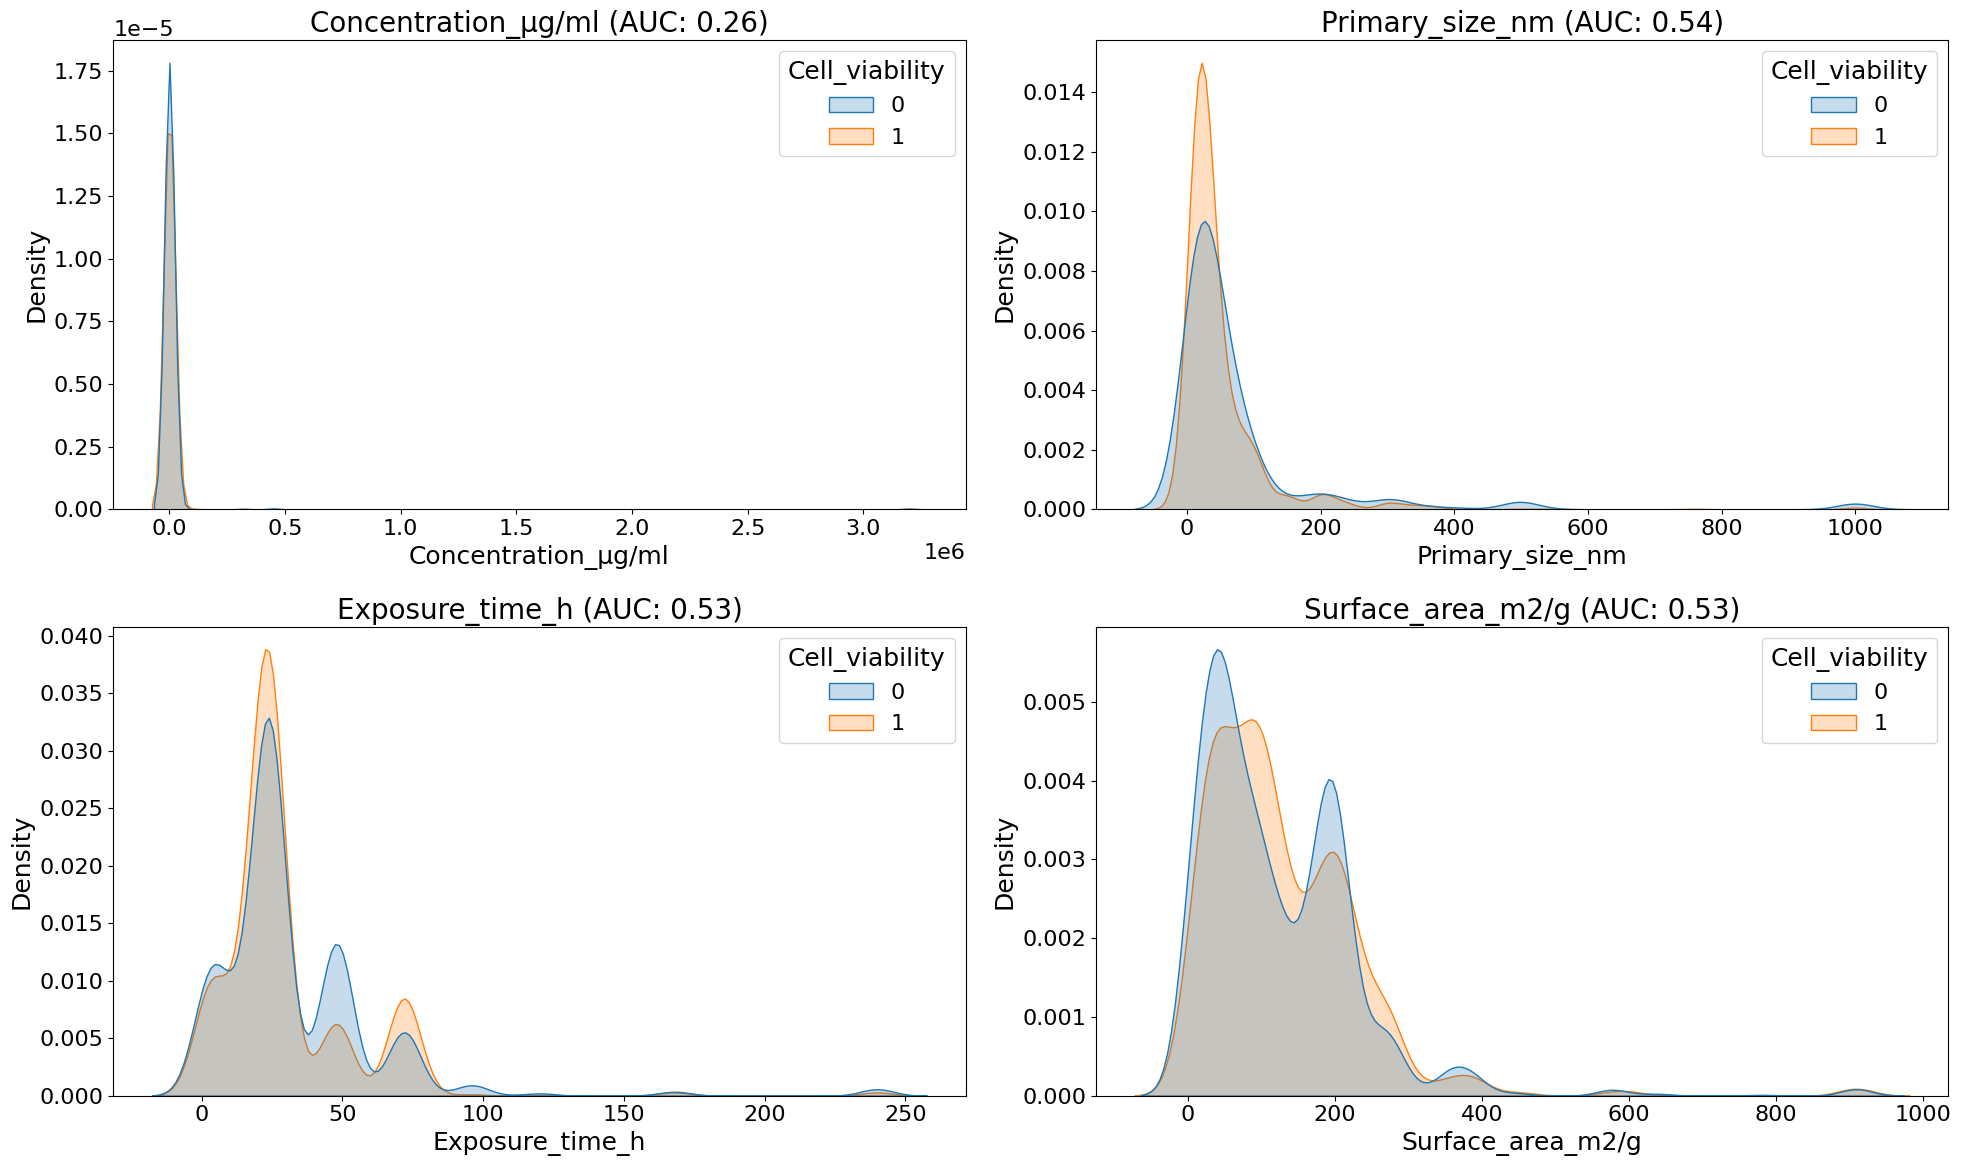

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({
    "font.size": 18,       # 所有文本的基础字号（标题、坐标轴、刻度等）
    "axes.titlesize": 20,  # 子图标题字号
    "axes.labelsize": 18,  # x/y 轴标签字号
    "xtick.labelsize": 16, # x 轴刻度字体
    "ytick.labelsize": 16, # y 轴刻度字体
    "legend.fontsize": 16  # 图例字体
})
# 假设 df_numeric 里已经包含分类标签列 'target'
# 如果你的标签列名不同，请替换 'target'
fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # 2x3 网格，可按需要调整行列数

# 遍历除目标列外的所有特征
for i, feature in enumerate(df_numeric.columns.drop('Cell_viability')):
    print(feature)
    ax = axs[i // 2, i % 2]  # 行列索引

    # 按类别画 KDE 分布
    sns.kdeplot(
        data=df_numeric,
        x=feature,
        hue='Cell_viability',
        fill=True,
        common_norm=False,
        ax=ax
    )

    # 计算单变量 Logistic 回归的 AUC
    X = df_numeric[[feature]].values
    y = df_numeric['Cell_viability'].values
    # 为避免数值问题，保证特征不是常数
    if np.std(X) > 0:
        model = LogisticRegression(max_iter=200).fit(X, y)
        y_prob = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, y_prob)
        ax.set_title(f"{feature} (AUC: {auc:.2f})")
    else:
        ax.set_title(f"{feature} (AUC: N/A)")
    
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

plt.tight_layout()
plt.savefig("./Scatter_KDE_Classification.png", format="png", dpi=300)
plt.show()
